In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
os.listdir('/kaggle/input')
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dataset_folder = '/kaggle/input/h-and-m-personalized-fashion-recommendations'
print(os.listdir(dataset_folder))

['sample_submission.csv', 'articles.csv', 'transactions_train.csv', 'images', 'customers.csv']


### Data Loading

In [3]:
articles_df = pd.read_csv(f'{dataset_folder}/articles.csv')
transactions_df = pd.read_csv(f'{dataset_folder}/transactions_train.csv')
customers_df = pd.read_csv(f'{dataset_folder}/customers.csv')

### Data Filtering

In [4]:
# Filter the selected date range (6 weeks)
transactions_df['t_dat'] = pd.to_datetime(transactions_df['t_dat'])
start_date = '2020-08-12'
end_date = '2020-09-22'
transactions_df = transactions_df[(transactions_df['t_dat'] >= start_date) & (transactions_df['t_dat'] <= end_date)]

### Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


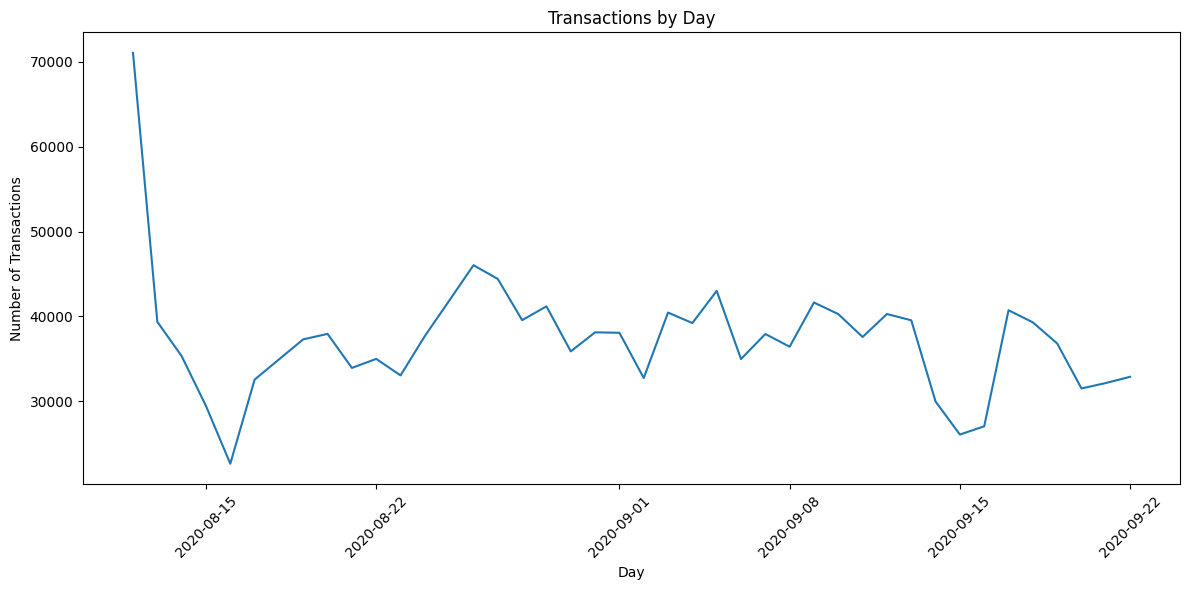

In [5]:
# Ensure the 't_dat' column in transactions_df is in datetime format
transactions_df['t_dat'] = pd.to_datetime(transactions_df['t_dat'])

# Group transactions by day and count them
trans_by_day = transactions_df.groupby(transactions_df['t_dat'].dt.date).size()

# Plot the daily transactions
plt.figure(figsize=(12, 6))
sns.lineplot(x=trans_by_day.index, y=trans_by_day.values)
plt.title('Transactions by Day')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


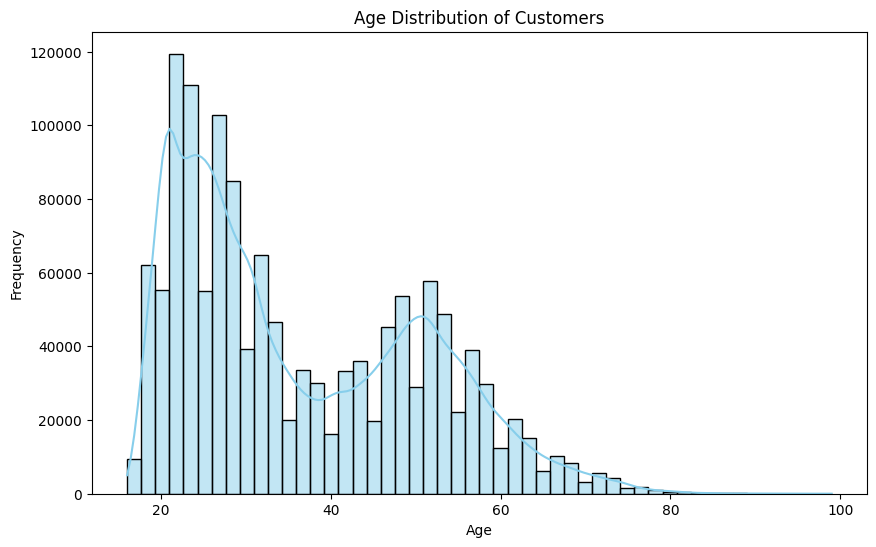

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


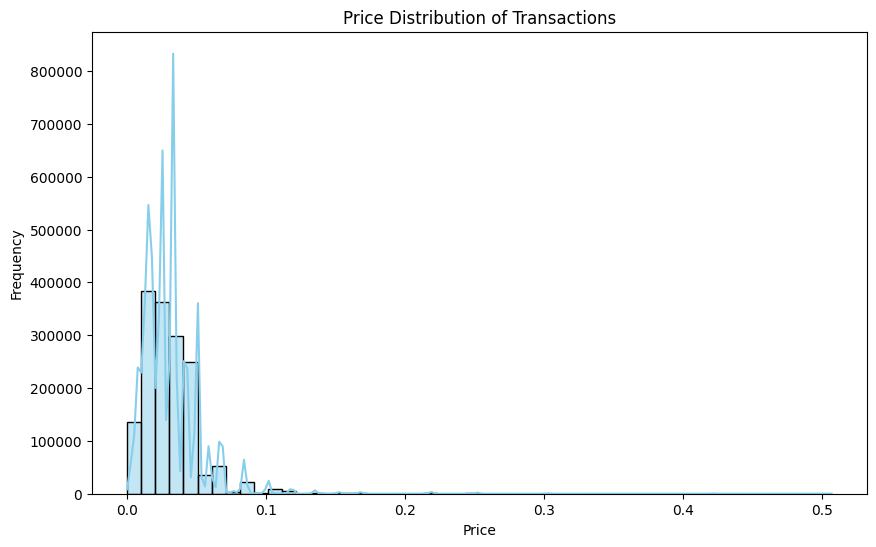

In [6]:
# Histogram for age distribution
plt.figure(figsize=(10, 6))
sns.histplot(customers_df['age'], bins=50, kde=True, color='skyblue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('age_distribution.png', dpi=300)  
plt.show()

# Histogram for price distribution
plt.figure(figsize=(10, 6))
sns.histplot(transactions_df['price'], bins=50, kde=True, color='skyblue')
plt.title('Price Distribution of Transactions')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('price_distribution.png', dpi=300)
plt.show()

### Data Preprocessing
We began by dropping irrelevant columns and handling missing values to get clean data.

In [7]:
# Drop unnecessary columns directly after filtering
articles_df.drop(columns=['product_code', 'product_type_no', 'graphical_appearance_no', 
                   'colour_group_code','colour_group_name', 'perceived_colour_value_id','perceived_colour_value_name', 'department_no', 
                   'department_name','index_code', 'garment_group_no', 'garment_group_name','section_no', 'section_name','index_group_no'], 
          inplace=True)
customers_df.drop(columns=['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'postal_code'], inplace=True)
transactions_df.drop(columns=['sales_channel_id'], inplace=True)

In [8]:
# Check if any null values
print(articles_df.isnull().sum())
print(customers_df.isnull().sum())
print(transactions_df.isnull().sum())

article_id                        0
prod_name                         0
product_type_name                 0
product_group_name                0
graphical_appearance_name         0
perceived_colour_master_id        0
perceived_colour_master_name      0
index_name                        0
index_group_name                  0
detail_desc                     416
dtype: int64
customer_id        0
age            15861
dtype: int64
t_dat          0
customer_id    0
article_id     0
price          0
dtype: int64


In [9]:
# Drop null values
articles_df.dropna(inplace=True)
customers_df.dropna(inplace=True)
transactions_df.dropna(inplace=True)

In [10]:
# Check if any duplicates
print(articles_df.duplicated().sum())
print(customers_df.duplicated().sum())
print(transactions_df.duplicated().sum())

0
0
136681


Filtered for articles purchased more than 100 times, then focusing on the popular products, where the transaction counts between 100 and 500.

In [11]:
# Get the popular articles

# Calculate trans times for each article
article_sales = transactions_df.groupby('article_id').size().reset_index(name='transaction_count')
# Set a top selling threshold
top_selling_thre = 100
df_ts = article_sales[article_sales['transaction_count'] > top_selling_thre]

print(f"The number of top selling items: {len(df_ts)}")

The number of top selling items: 3695


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


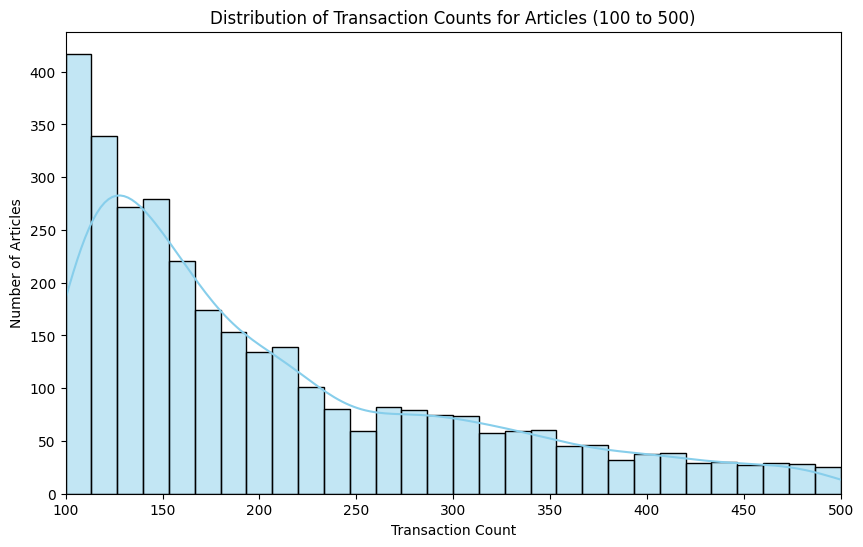

In [12]:
# Filter the article_sales DataFrame for transaction counts between 100 and 500
filtered_article_sales = article_sales[(article_sales['transaction_count'] >= 100) & (article_sales['transaction_count'] <= 500)]

# Plotting the histogram for filtered transaction counts
plt.figure(figsize=(10, 6))
sns.histplot(filtered_article_sales['transaction_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Transaction Counts for Articles (100 to 500)')
plt.xlabel('Transaction Count')
plt.ylabel('Number of Articles')
plt.xlim(100, 500)  # Set x-axis limits to show only 0-500
plt.show()


In [13]:
# Merge table
df_ta = pd.merge(transactions_df, articles_df, on='article_id', how='inner')
df_merged = pd.merge(df_ta, customers_df, on='customer_id', how='inner')

# Filter Top Sell Items
df_merged_ts = df_merged[df_merged['article_id'].isin(df_ts['article_id'])]


In [14]:
df_merged.shape
df_merged_ts.shape
df_merged_ts.head
df_merged_ts.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'prod_name',
       'product_type_name', 'product_group_name', 'graphical_appearance_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'index_name', 'index_group_name', 'detail_desc', 'age'],
      dtype='object')

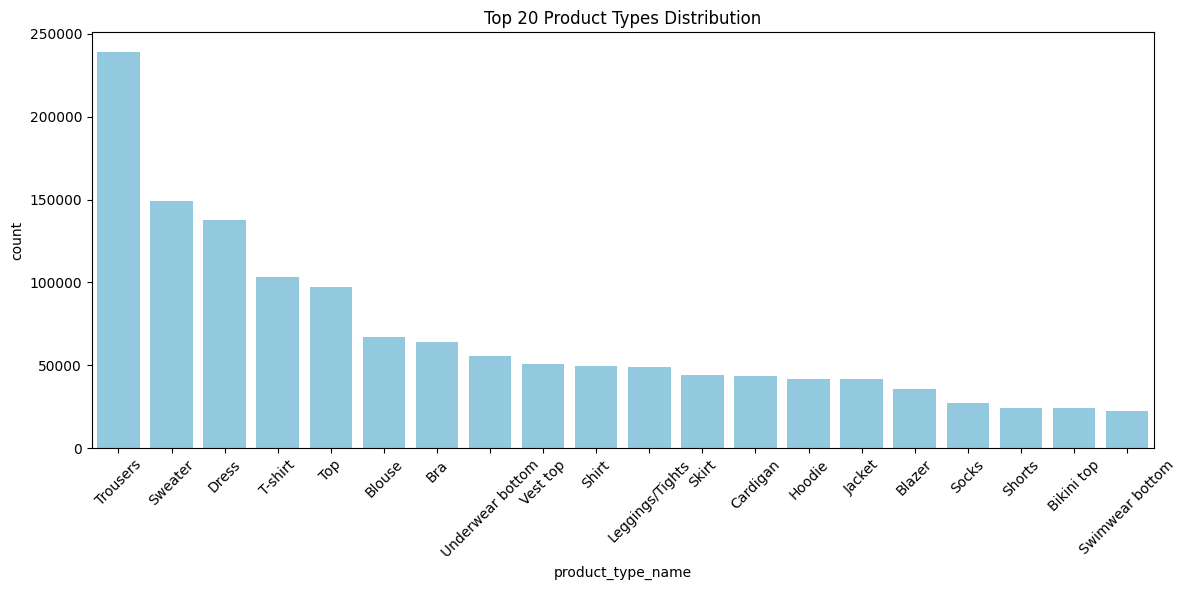

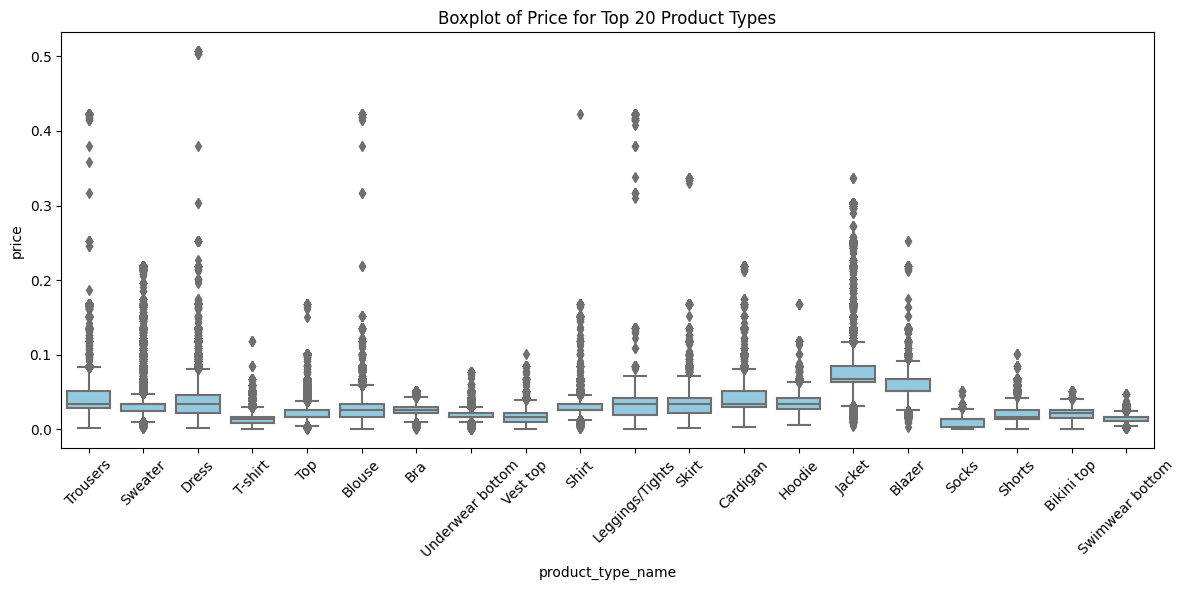

In [15]:
top_20_product_types = df_merged['product_type_name'].value_counts().index[:20]

plt.figure(figsize=(12, 6))
sns.countplot(x='product_type_name', data=df_merged[df_merged['product_type_name'].isin(top_20_product_types)], 
              color='skyblue', 
              order=df_merged['product_type_name'].value_counts().iloc[:20].index) 
plt.title('Top 20 Product Types Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='product_type_name', y='price', data=df_merged[df_merged['product_type_name'].isin(top_20_product_types)], 
            order=df_merged['product_type_name'].value_counts().iloc[:20].index, color = 'skyblue') 
plt.title('Boxplot of Price for Top 20 Product Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Check the number of unique values for each feature

categorical_f = ['index_name', 'product_type_name', 'graphical_appearance_name', 'perceived_colour_master_name']
for col in categorical_f:
    print(f"{col} unique values: {df_merged_ts[col].nunique()}")


index_name unique values: 8
product_type_name unique values: 70
graphical_appearance_name unique values: 25
perceived_colour_master_name unique values: 18


Used OneHotEncoder to convert categorical variables into numerical format as machine learning models typically require numerical input. 

In [17]:
# Use OneHotEncoder on categorical features used for evaluation
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_f = encoder.fit_transform(df_merged_ts[categorical_f])
df_enc = pd.DataFrame(encoded_f, columns=encoder.get_feature_names_out(categorical_f))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Combined product names and descriptions and used TF-IDF for text analysis to represent the text data meaningfully.
TF measures how often a word appears in a document while IDF measures how rare or common a word is across all documents. We calculated TF-IDF score by multiplying these two values, which indicates the relevance of a word to a specific product relative to the entire dataset.


/tmp/ipykernel_116/1227423974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_ts['combined_text'] = df_merged_ts['prod_name'] + ' ' + df_merged_ts['detail_desc']


    1p   2p  2pk   3p   7p  added  adjustable  against  airy    amelie  ...  \
0  0.0  0.0  0.0  0.0  0.0    0.0         0.0      0.0   0.0  0.298269  ...   
1  0.0  0.0  0.0  0.0  0.0    0.0         0.0      0.0   0.0  0.000000  ...   
2  0.0  0.0  0.0  0.0  0.0    0.0         0.0      0.0   0.0  0.000000  ...   
3  0.0  0.0  0.0  0.0  0.0    0.0         0.0      0.0   0.0  0.000000  ...   
4  0.0  0.0  0.0  0.0  0.0    0.0         0.0      0.0   0.0  0.000000  ...   

   wired  wireless      with      wool  worn     woven  wrapover  yoke  zip  \
0    0.0       0.0  0.103110  0.176421   0.0  0.000000       0.0   0.0  0.0   
1    0.0       0.0  0.044707  0.000000   0.0  0.000000       0.0   0.0  0.0   
2    0.0       0.0  0.075319  0.000000   0.0  0.000000       0.0   0.0  0.0   
3    0.0       0.0  0.063220  0.000000   0.0  0.000000       0.0   0.0  0.0   
4    0.0       0.0  0.071466  0.000000   0.0  0.238308       0.0   0.0  0.0   

   zipped  
0     0.0  
1     0.0  
2     0.0  
3 

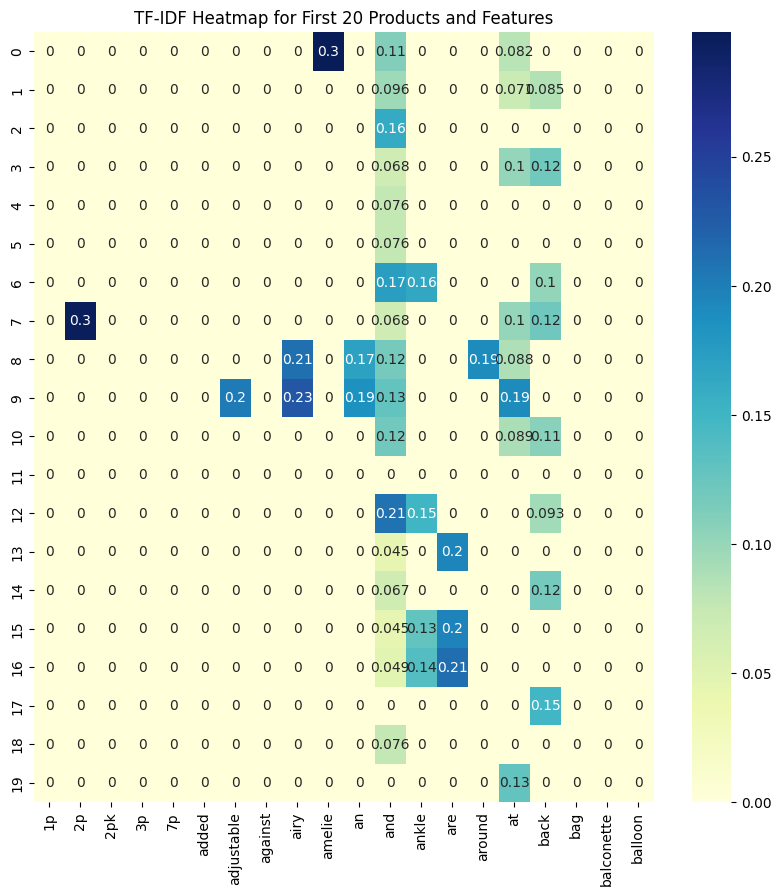

In [18]:
# Combine prod_name and detail_desc for TF-IDF
df_merged_ts['combined_text'] = df_merged_ts['prod_name'] + ' ' + df_merged_ts['detail_desc']
tfidf_vectorizer = TfidfVectorizer(max_features=400)
combined_tfidf = tfidf_vectorizer.fit_transform(df_merged_ts['combined_text']).toarray()
df_tfidf = pd.DataFrame(combined_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
print(df_tfidf.head())

# Plot a heat map for first 20 products and features
plt.figure(figsize=(10, 10))
sns.heatmap(df_tfidf.iloc[:20, :20], cmap='YlGnBu', annot=True)  
plt.title('TF-IDF Heatmap for First 20 Products and Features')
plt.savefig('/kaggle/working/tfidf_heatmap.png')
plt.show()


Normalized numerical features using StandardScaler to ensure that all features contributed equally to the model.

In [19]:
# Normalize the numerical features

numerical_f = ['price']

scaler = StandardScaler()
df_nor = scaler.fit_transform(df_merged[numerical_f])
df_nor = pd.DataFrame(df_nor, columns=numerical_f)

# Normalize the price feature
scaler = StandardScaler()
normalized_price = scaler.fit_transform(df_merged_ts[numerical_f]) 
df_nor = pd.DataFrame(normalized_price, columns=['normalized_price'])

# Combine all features
df_all = pd.concat([df_enc, df_tfidf, df_nor], axis=1)
df_all['t_dat'] = df_merged_ts['t_dat'].values
df_all['customer_id'] = df_merged_ts['customer_id'].values
df_all['article_id'] = df_merged_ts['article_id'].values

print(df_all.head())
df_all.to_csv('/kaggle/working/df_all.csv', index=False)


   index_name_Children Sizes 134-170  index_name_Divided  \
0                                0.0                 0.0   
1                                0.0                 0.0   
2                                0.0                 0.0   
3                                0.0                 0.0   
4                                0.0                 0.0   

   index_name_Ladies Accessories  index_name_Ladieswear  \
0                            0.0                    1.0   
1                            0.0                    0.0   
2                            0.0                    1.0   
3                            0.0                    0.0   
4                            0.0                    1.0   

   index_name_Lingeries/Tights  index_name_Menswear  index_name_Sport  \
0                          0.0                  0.0               0.0   
1                          0.0                  0.0               1.0   
2                          0.0                  0.0              

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


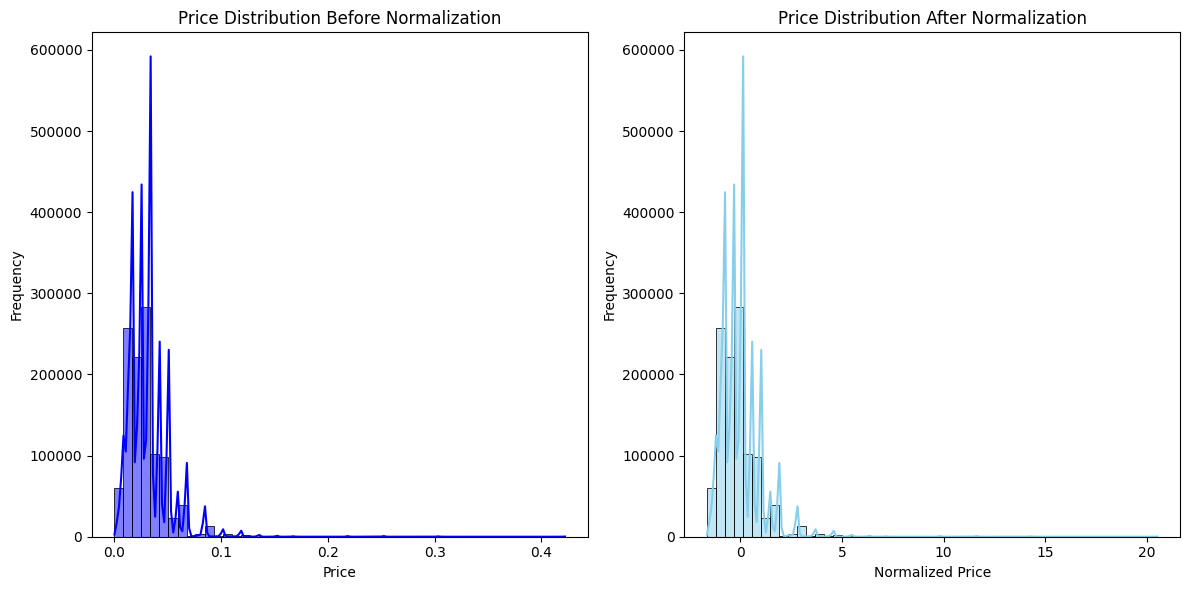

In [20]:
# Plot Price distribution before/after normalization
price_original = df_merged_ts['price']
price_normalized = df_nor['normalized_price']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
sns.histplot(price_original, kde=True, color='blue', bins=50)
plt.title('Price Distribution Before Normalization')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # 1行2列，第2个子图
sns.histplot(price_normalized, kde=True, color='skyblue', bins=50)
plt.title('Price Distribution After Normalization')
plt.xlabel('Normalized Price')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Model Building

In [21]:
# Split data into train and test set
start_date_train = '2020-08-12'
end_date_train = '2020-09-15'
start_date_test = '2020-09-16'
end_date_test = '2020-09-22'

df_train = df_all[(df_all['t_dat'] >= start_date_train) & (df_all['t_dat'] <= end_date_train)]
df_test = df_all[(df_all['t_dat'] >= start_date_test) & (df_all['t_dat'] <= end_date_test)]

df_train = df_train.drop(columns=['t_dat'])
df_test = df_test.drop(columns=['t_dat'])


To get the customer Preferences, I grouped customer data by customer ID and calculated the mean of relevant features to summarize each customer’s preferences, and get all articles with their features.

In [22]:
# Get all customers and and their previous purchases with features
customer_preferences = df_train.groupby('customer_id').mean().reset_index()
customer_preferences_numeric = customer_preferences.select_dtypes(include=[np.number])
if 'article_id' in customer_preferences_numeric.columns:
    customer_preferences_numeric = customer_preferences_numeric.drop(columns=['article_id'])

# Get all articles and their features
article_features = df_all.drop_duplicates(subset=['article_id']).set_index('article_id')
article_features_numeric = article_features.select_dtypes(include=[np.number])

print(customer_preferences_numeric.columns)
print(article_features_numeric.columns)
print("Datasize of customer_preferences_numeric:", customer_preferences_numeric.shape)
print("Datasize of article_features_numeric:", article_features_numeric.shape)

Index(['index_name_Children Sizes 134-170', 'index_name_Divided',
       'index_name_Ladies Accessories', 'index_name_Ladieswear',
       'index_name_Lingeries/Tights', 'index_name_Menswear',
       'index_name_Sport', 'product_type_name_Ballerinas',
       'product_type_name_Belt', 'product_type_name_Bikini top',
       ...
       'wireless', 'with', 'wool', 'worn', 'woven', 'wrapover', 'yoke', 'zip',
       'zipped', 'normalized_price'],
      dtype='object', length=518)
Index(['index_name_Children Sizes 134-170', 'index_name_Divided',
       'index_name_Ladies Accessories', 'index_name_Ladieswear',
       'index_name_Lingeries/Tights', 'index_name_Menswear',
       'index_name_Sport', 'product_type_name_Ballerinas',
       'product_type_name_Belt', 'product_type_name_Bikini top',
       ...
       'wireless', 'with', 'wool', 'worn', 'woven', 'wrapover', 'yoke', 'zip',
       'zipped', 'normalized_price'],
      dtype='object', length=518)
Datasize of customer_preferences_numeric: (2

By calculating the cosine similarity between customer preferences and article features, we were able to determine how related each customer is to the available products.

In [23]:
# Calculate the similarity between customer purchases and article features
similarity_comparison = cosine_similarity(customer_preferences_numeric, article_features_numeric)

Finally, generated the top 12 recommendations for each customer based on the similarity scores.

In [24]:
# Recommendations
n = 12  # the number of recommendations to each customer
recs = pd.DataFrame(similarity_comparison, index=customer_preferences['customer_id'], columns=article_features.index)

# Generate recommended articles
recs['recommended_articles'] = recs.apply(lambda row: row.nlargest(n).index.tolist(), axis=1)

# Evaluation Metrics
act_purs = df_test.groupby('customer_id')['article_id'].apply(list).reset_index()
pred_purs = pd.DataFrame({'customer_id': recs.index, 'recommended_articles': recs['recommended_articles'].values})

# Merge actual and predicted purchases
merged_res = pd.merge(pred_purs, act_purs, on='customer_id', how='left')

merged_res.head()
recs.columns

Index([             896152002,              730683050,              927530004,
                    791587015,              762846008,              762846029,
                    751471022,              611415035,              897684002,
                    868876001,
       ...
                    889550001,              918890001,              903840002,
                    855706009,              910457001,              881570005,
                    907149001,              864216017,              934536001,
       'recommended_articles'],
      dtype='object', name='article_id', length=3694)

### Result and Conclusion

To evaluate the model, we used Mean Average Precision at 12, which measures how relevant the top 12 recommended items are to the customers. Our final MAP@12 score for this approach was 0.00132. Since this result is clearly not ideal, therefore, we will continue proceeding with a new approach.

In [25]:
# Function to calculate the average precision @K for a customer
def apk(actual, predicted, k=12):
    if not actual:
        return 0.0

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(actual), k)

# Function to calculate the mean average recision @K for all customers
def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

k = 12
map_at_k = mapk(act_purs['article_id'], recs['recommended_articles'], k)
print(f"MAP@{k}: {map_at_k:.5f}")


MAP@12: 0.00124


In [26]:
# Calculate hit rate
def hit_rate(row):
    recommended_set = set(row['recommended_articles'])  
    actual_set = set(row['article_id']) if isinstance(row['article_id'], list) else set()
    return int(len(recommended_set & actual_set) > 0)  # if there is a match return 1, 0 otherwise

merged_res['hit'] = merged_res.apply(hit_rate, axis=1)
total_hit_rate = merged_res['hit'].mean()

print(f"Overall Hit Rate: {total_hit_rate:.5f}")

Overall Hit Rate: 0.01108
